# GateRNN
本篇主要是想利用pytorch复现《深度学习进阶--自然语言处理》第六章内容，读取数据分析结果依旧用书中代码。
RNN部分主要参考 
https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

GRU文档：https://pytorch.org/docs/stable/generated/torch.nn.GRU.html#torch.nn.GRU


In [1]:
import torch
torch.cuda.device_count()

device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device)

## 模型创建

In [5]:
import torch
import torch.nn as nn

# torch.cuda.is_available
# device = torch.cuda.get_device_name() if torch.cuda.is_available() else "cpu"



print(f"use device {device} ")

class Rnnlm(nn.Module):
    def __init__(self,vocab_size=10000,wordvec_size=1000):
        super(Rnnlm,self).__init__()
        self.embedding = nn.Embedding(vocab_size,wordvec_size)
        self.rnn = nn.LSTM(wordvec_size, 128 ,batch_first = True,bias=False)
        self.affine = nn.Linear(128,vocab_size,bias=False)
        self.softmax = nn.Softmax(dim=-1)
        self.flatten = nn.Flatten(0,-2)

    def forward(self,input,h_c):
        embeded = self.embedding(input)
        output = embeded


        output, hc = self.rnn(output,h_c)
        output = self.affine(output)
        output = self.softmax(output)
        output = self.flatten(output)
        return output,hc


    ## 测试模型
x  = [
        [1,2,3,4],
        [5,6,7,8],
        [9,10,11,12]
    ]

x = torch.Tensor(x).long().to(device = device)

input = x[:,   :    -1].to(device=device)
target =x[:,1  : ].to(device=device)

print(input)






#hiden = torch.zeros((1,3,5),dtype=torch.float32)



tmodel = Rnnlm(50,5).to(device = device)


target = torch.flatten(target)
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.SGD(tmodel.parameters(),lr = 0.9)
hidden = None
for i in range(1000):
   
    out ,hidden= tmodel(input,hidden)

    loss = criterion(out,target)

  
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    hidden = hidden[0].detach(),hidden[1].detach()


# embed = nn.Embedding(20,5)
# input = embed(x)
# print(f"input.shape:{input.shape}")

# lstm = nn.LSTM(5,20)
# c = None

# output,c = lstm(input,None)

# print(output.shape)
# print(c)




# print(f"out.shape:{out.size()}")

# softmax = nn.Softmax(dim=-1)
# test = torch.zeros((2,5,4),dtype=torch.float32)
# test[:,:,3] = 1

# test[0,2,0] = 3
# print(test)
# print(softmax(test))



use device cpu 
tensor([[ 1,  2,  3],
        [ 5,  6,  7],
        [ 9, 10, 11]])
-0.020057281479239464
-0.019968368113040924
-0.019959500059485435
-0.01997017115354538
-0.019984552636742592
-0.019999433308839798
-0.020014338195323944
-0.020029256120324135
-0.020044192671775818
-0.02005915157496929
-0.020074142143130302
-0.02008916065096855
-0.02010420896112919
-0.02011929266154766
-0.02013440616428852
-0.020149551331996918
-0.020164730027318
-0.02017994038760662
-0.020195184275507927
-0.020210465416312218
-0.020225778222084045
-0.020241130143404007
-0.020256517454981804
-0.020271936431527138
-0.020287400111556053
-0.020302897319197655
-0.02031843550503254
-0.02033401094377041
-0.02034962736070156
-0.020365282893180847
-0.020380977541208267
-0.020396718755364418
-0.020412499085068703
-0.02042832225561142
-0.020444191992282867
-0.020460104569792747
-0.02047606185078621
-0.020492063835263252
-0.020508112385869026
-0.02052421122789383
-0.020540351048111916
-0.02055654674768448
-0.0205727

In [9]:
a = torch.tensor([[7]]).to(device=device)
h_c = None
tmodel.to(device=device)

out, hc = tmodel.forward(a,None)
print(out.topk(5))

torch.return_types.topk(
values=tensor([[0.2874, 0.0415, 0.0411, 0.0298, 0.0211]], grad_fn=<TopkBackward0>),
indices=tensor([[11,  8,  3,  2, 12]]))


In [ ]:

## 训练弄型
def train(model:Rnnlm,criterion,optimizer,input,target,h = None):
    optimizer.zero_grad()
    pred ,h = model(input,h)
    loss = criterion(pred)
    loss.backfard()
    optimizer.step()

    return loss.deta,h


In [71]:
## 自宝义数据集函数

import numpy as np
class LngDataSet:
    def __init__(self,  corpus:list, batch_size:int = 50,time_size:int=5,offset:int = 0 ):
        self.corpus = corpus
        self.batch_size = batch_size
        self.time_size = time_size
        clen = len(corpus) -1
        self.offset = offset
       

   

        self.remain = (clen -  offset) % (time_size * batch_size)
        corpus.extend(corpus[:(time_size *batch_size - self.remain)])

        self.bound_count = (len(corpus) - offset) // self.batch_size 


        


        self.batch_count =  (len(corpus) -  offset) // (time_size * batch_size)
        # if(self.remain != 0): self.batch_count += 1
       
        self.batch = 0

        # self.stars = [i * (time_size * batch_size)]
        


        
    ## 获取一个无限循环的数据集
    def getBatches(self):

        resultx = []
        resulty = []
        start = self.offset + (self.time_size  *  self.batch)
        for i in range(batch_size):

            s = start
            e= start + self.time_size

            b = self.corpus[s:e]
           
            resultx.append(self.corpus[start : (start + self.time_size)])

            resulty.append(self.corpus[start+1 : (start + self.time_size +1)])

            start += self.bound_count 

        self.batch += 1
        return self.batch < self.batch_count, np.array(resultx),np.array(resulty)

        

        

list = [i for i in range(10 * 6 * 3)]

ln = LngDataSet(list,time_size=10, batch_size=6,offset=2)

b = ln.getBatches()
print(b)
b = ln.getBatches()
print(b)


b = ln.getBatches()
print(b)





(True, array([[  2,   3,   4,   5,   6,   7,   8,   9,  10,  11],
       [ 32,  33,  34,  35,  36,  37,  38,  39,  40,  41],
       [ 62,  63,  64,  65,  66,  67,  68,  69,  70,  71],
       [ 92,  93,  94,  95,  96,  97,  98,  99, 100, 101],
       [122, 123, 124, 125, 126, 127, 128, 129, 130, 131]]), array([[  3,   4,   5,   6,   7,   8,   9,  10,  11,  12],
       [ 33,  34,  35,  36,  37,  38,  39,  40,  41,  42],
       [ 63,  64,  65,  66,  67,  68,  69,  70,  71,  72],
       [ 93,  94,  95,  96,  97,  98,  99, 100, 101, 102],
       [123, 124, 125, 126, 127, 128, 129, 130, 131, 132]]))
(True, array([[ 12,  13,  14,  15,  16,  17,  18,  19,  20,  21],
       [ 42,  43,  44,  45,  46,  47,  48,  49,  50,  51],
       [ 72,  73,  74,  75,  76,  77,  78,  79,  80,  81],
       [102, 103, 104, 105, 106, 107, 108, 109, 110, 111],
       [132, 133, 134, 135, 136, 137, 138, 139, 140, 141]]), array([[ 13,  14,  15,  16,  17,  18,  19,  20,  21,  22],
       [ 43,  44,  45,  46,  47,  48

In [ ]:
# def train_dataset(model:Rnnlm,
#  criterion = nn.CrossEntropyLoss(),
#  optimizer:torch.optim.Optimizer = None,
#  input = None ,
#  target = None
#   max_iters = 100,
#   batch_size = 500,
#   time_size = 10 ):


## 加载数据


### colab加载主公共模块

In [4]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append("/content/drive/MyDrive/ml/nlp/")

Mounted at /content/drive


### 本机环境中用当前前目录

In [14]:
import sys
sys.path.append("../")

In [64]:


import sys

import matplotlib.pyplot as plt
import numpy as np
from common.optimizer import SGD
from dataset import ptb
import time 
import math
import numpy as np



batch_size = 5

time_size = 10

wordvec_size = 100
hidden_size=100

lr = 0.1
max_epoch = 100


corpus , word_to_id,id_to_word = ptb.load_data('train')


corpus_size = 1000


#corpus = corpus[:corpus_size]
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]


data_size = len(corpus)
print("corpus size %d ,vocabulary size : %d, " % (corpus_size,vocab_size))

max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0


loss_count = 0
ppl_list = []


print(f"vocab_size = {vocab_size} wordvec_size= {wordvec_size} hidden_size = {hidden_size}")



device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = Rnnlm(vocab_size,wordvec_size)
model.to(device=device)

optimizer = torch.optim.SGD(model.parameters(), lr=2)

criterion = torch.nn.CrossEntropyLoss()


model.train()




corpus size 1000 ,vocabulary size : 10000, 
vocab_size = 10000 wordvec_size= 100 hidden_size = 100


Rnnlm(
  (embedding): Embedding(10000, 100)
  (rnn): LSTM(100, 128, bias=False, batch_first=True)
  (affine): Linear(in_features=128, out_features=10000, bias=False)
  (softmax): Softmax(dim=-1)
  (flatten): Flatten(start_dim=0, end_dim=-2)
)

## 训练数据读取






In [61]:
import numpy as np
import time

time_size = 20
batch_size = 200

max_grad = 0.25
criterion = torch.nn.NLLLoss()


# optimizer = torch.optim.SGD(model.parameters(),lr=0.8)

eval_iterval = 20
for epoch in range(max_epoch):

    
   
    for  iter in range(max_iters -1):


        start_idx = iter * (batch_size * time_size)
        end_idx = (iter + 1) * (batch_size * time_size)

        batch_x = xs[start_idx:end_idx]
        batch_t = ts[start_idx:end_idx]


        # batch_x = xs[0 : 500 * time_size]
        # batch_t = ts[0 : 500 * time_size]

 
        batch_x = batch_x.reshape(batch_size,time_size) 
        #batch_t = batch_t.reshape(batch_size,time_size)


        batch_x = torch.from_numpy(batch_x).to(device=device)
        batch_t = torch.from_numpy(batch_t).to(device=device)


        h = None
        model.zero_grad()
        pred  ,h = model(batch_x,h)
        loss = criterion(pred,batch_t)
        loss.backward()
        
      #   params = model.parameters()

      #   for param in params:
      # ##    print(param.grad.data)
      #     param.data.add_(param.grad.data, alpha= -1)
      
       # loss , h = train(model,criterion,optimizer,batch_x,batch_t,h,max_grad)

      #  print(loss)

        total_loss += loss.item()
        loss_count += 1
        if (iter % eval_iterval) == 0:
            ppl = math.exp(total_loss / loss_count)
            print(f"epoch  {epoch }/{max_epoch}\t|\t time :{time.time() - start_time}[s] \t|\t perplexity:{ppl}")
            total_loss = 0
            loss_count = 0

epoch  0/100	|	 time :1086.4924097061157[s] 	|	 perplexity:0.999899750914982
epoch  0/100	|	 time :1087.5391659736633[s] 	|	 perplexity:0.999900220425582
epoch  0/100	|	 time :1088.5887424945831[s] 	|	 perplexity:0.999900170347254
epoch  0/100	|	 time :1089.635405778885[s] 	|	 perplexity:0.9999001203784206
epoch  0/100	|	 time :1090.6807444095612[s] 	|	 perplexity:0.9999002015816411
epoch  0/100	|	 time :1091.7277917861938[s] 	|	 perplexity:0.9999001484542646
epoch  0/100	|	 time :1092.7754604816437[s] 	|	 perplexity:0.999900194859691
epoch  0/100	|	 time :1093.8247191905975[s] 	|	 perplexity:0.999900214048114
epoch  0/100	|	 time :1094.8718495368958[s] 	|	 perplexity:0.9999001343370424
epoch  0/100	|	 time :1095.9204709529877[s] 	|	 perplexity:0.9999001413245381
epoch  0/100	|	 time :1096.9668962955475[s] 	|	 perplexity:0.9999001853102222
epoch  0/100	|	 time :1098.0137898921967[s] 	|	 perplexity:0.9999002183434108


ValueError: ignored

In [6]:
print(model)

Rnnlm(
  (embedding): Embedding(10000, 100)
  (rnn): LSTM(100, 256, bias=False, batch_first=True)
  (affine): Linear(in_features=256, out_features=10000, bias=False)
  (softmax): Softmax(dim=-1)
  (flatten): Flatten(start_dim=0, end_dim=-2)
)


In [ ]:
import numpy as np
import time

print(model)

print(device)

# model = Rnnlm(100,wordvec_size)
# model.to(device=device)

batch_size = 500
time_size = 10
max_grad = 0.25

max_iters = data_size // (batch_size * time_size)
criterion = torch.nn.NLLLoss()


adam = torch.optim.Adam(model.parameters(),lr=0.001)

eval_iterval = 20

ppl_list = []

loss_list = []
loss = 0
h = None
start_time = time.time()

total_loss = 0
for epoch in range(max_epoch):

    
   
    for  iter in range(max_iters -1):




        start_idx = iter * (batch_size * time_size)
        end_idx = (iter + 1) * (batch_size * time_size)

        # print(f"start={start_idx}")
        # print(f"end = {end_idx}")

        # start_idx = 0 * (batch_size * time_size)
        # end_idx = (0 + 1) * (batch_size * time_size)

        batch_x = xs[start_idx:end_idx]
        batch_t = ts[start_idx:end_idx]


        # batch_x = xs[0 : 500 * time_size]
        # batch_t = ts[0 : 500 * time_size]

 
        batch_x = batch_x.reshape(batch_size,time_size) 
        #batch_t = batch_t.reshape(batch_size,time_size)


        batch_x = torch.from_numpy(batch_x).to(device=device)
        batch_t = torch.from_numpy(batch_t).to(device=device)

        adam.zero_grad()
        h = None
        pred  ,h = model(batch_x,h)
        l  = criterion(pred,batch_t)
        l.backward()

        total_loss += l.item()
        adam.step()

        total_loss += l.to("cpu").item()

       # h = None
        # optimizer.zero_grad()
        # model.zero_grad()
        # pred  ,h = model(batch_x,h)
        # l  = criterion(pred,batch_t)
        # total_loss += l.item()
        # loss += l

        #params = model.parameters()

    #     for param in params:
    #   ##    print(param.grad.data)
    #       param.data.add_(param.grad.data, alpha= -1)
      
       # loss , h = train(model,criterion,optimizer,batch_x,batch_t,h,max_grad)

      #  print(loss)
      
        

        # total_loss += loss.item()
        loss_count += 1
        if (iter % eval_iterval) == 0:




            loss ,h = 0,None

            ppl = np.exp(total_loss / loss_count)
            avg_loss = total_loss / loss_count
            print(f"epoch  {epoch }/{max_epoch}\t|\t time :{time.time() - start_time}[s] \t|\t perplexity:{ppl},\t avgloss : {avg_loss}")
            
#            ppl_list.append(ppl)
          
            loss_list.append(avg_loss)
            total_loss , loss_count = 0, 0


Rnnlm(
  (embedding): Embedding(10000, 100)
  (rnn): LSTM(100, 128, bias=False, batch_first=True)
  (affine): Linear(in_features=128, out_features=10000, bias=False)
  (softmax): Softmax(dim=-1)
  (flatten): Flatten(start_dim=0, end_dim=-2)
)
cuda:0
epoch  0/100	|	 time :0.06241655349731445[s] 	|	 perplexity:0.9810969090254982,	 avgloss : -0.019084038337071736
epoch  0/100	|	 time :1.2657411098480225[s] 	|	 perplexity:0.7469398244196286,	 avgloss : -0.2917706534266472
epoch  0/100	|	 time :2.4728100299835205[s] 	|	 perplexity:0.7508546279191425,	 avgloss : -0.2865432173013687
epoch  0/100	|	 time :3.6772983074188232[s] 	|	 perplexity:0.7558234189434639,	 avgloss : -0.27994750291109083
epoch  0/100	|	 time :4.884859561920166[s] 	|	 perplexity:0.7462584330370736,	 avgloss : -0.2926833137869835
epoch  0/100	|	 time :6.088580846786499[s] 	|	 perplexity:0.7473972783288285,	 avgloss : -0.2911584034562111
epoch  0/100	|	 time :7.293252944946289[s] 	|	 perplexity:0.7461015658010103,	 avgloss :

In [72]:
import numpy as np
import time



print(device)

# model = Rnnlm(100,wordvec_size)
# model.to(device=device)

batch_size = 5
time_size = 2
max_grad = 0.25


criterion = torch.nn.CrossEntropyLoss()


adam = torch.optim.Adam(model.parameters(),lr=0.001)

eval_iterval = 20

ppl_list = []

loss_list = []
loss = 0
h = None
start_time = time.time()

total_loss = 0
h = None
for epoch in range(max_epoch):

    ds =   LngDataSet(corpus.tolist(),batch_size=batch_size,time_size=time_size,offset = epoch % time_size)
    iter = 0
    while True:
        iter += 1
        has_next , batch_x, batch_t = ds.getBatches()

        if(not has_next): break

        batch_x, batch_t  = torch.tensor(batch_x),torch.Tensor(batch_t).to(device=device,dtype=torch.long).flatten()
    

    
        model.zero_grad()
        pred  ,h = model(batch_x,h)
        loss = criterion(pred,batch_t)
        loss.backward()
        adam.step()
        h = (h[0].detach(),h[1].detach())


        total_loss += loss.item() 


        loss_count += 1

        if (iter % eval_iterval) == 0:
            loss ,h = 0,None
            ppl = np.exp(total_loss / loss_count)
            avg_loss = total_loss / loss_count
            print(f"epoch  {epoch }/{max_epoch}\t|\t time :{time.time() - start_time}[s] \t|\t perplexity:{ppl},\t avgloss : {avg_loss}")
            
#            ppl_list.append(ppl)
          
            loss_list.append(avg_loss)
            total_loss , loss_count = 0, 0


cpu
epoch  0/100	|	 time :0.40564680099487305[s] 	|	 perplexity:255.1362890215774,	 avgloss : 5.541797869133227
epoch  0/100	|	 time :0.7980430126190186[s] 	|	 perplexity:9235.29424495198,	 avgloss : 9.130787754058838
epoch  0/100	|	 time :1.17421293258667[s] 	|	 perplexity:9374.165230501692,	 avgloss : 9.14571280479431
epoch  0/100	|	 time :1.557075023651123[s] 	|	 perplexity:9200.641282900719,	 avgloss : 9.127028465270996
epoch  0/100	|	 time :1.9461359977722168[s] 	|	 perplexity:9070.690747406697,	 avgloss : 9.11280369758606
epoch  0/100	|	 time :2.304921865463257[s] 	|	 perplexity:9228.72753444958,	 avgloss : 9.130076456069947
epoch  0/100	|	 time :2.6880300045013428[s] 	|	 perplexity:9310.982264188548,	 avgloss : 9.138949871063232
epoch  0/100	|	 time :3.046678066253662[s] 	|	 perplexity:9221.130386552235,	 avgloss : 9.129252910614014
epoch  0/100	|	 time :3.41554594039917[s] 	|	 perplexity:9011.618601529088,	 avgloss : 9.106269979476929
epoch  0/100	|	 time :3.792663097381592[s] 

KeyboardInterrupt: 

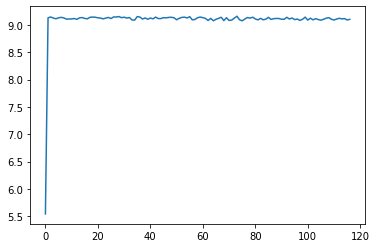

In [73]:
import matplotlib.pyplot as plt
import numpy as np


x = np.arange(len(loss_list))
plt.plot(x,loss_list)
plt.show()

In [86]:
str = " ".join( id_to_word[i] for i in corpus[0:100])
print(str)

id = word_to_id["i"]
print(id)


input = torch.Tensor([[id]]).to(device = device).long()
tt,h = model.forward(input,None)
print(tt)
dd = tt.topk(100)
print(dd.indices.data)

# for i in dd.indices[0]:
#   print(i.item())

str=  " ".join( id_to_word[i.item()] for i in dd.indices[0])
print(str)

aer banknote berlitz calloway centrust cluett fromstein gitano guterman hydro-quebec ipo kia memotec mlx nahb punts rake regatta rubens sim snack-food ssangyong swapo wachter <eos> pierre <unk> N years old will join the board as a nonexecutive director nov. N <eos> mr. <unk> is chairman of <unk> n.v. the dutch publishing group <eos> rudolph <unk> N years old and former chairman of consolidated gold fields plc was named a nonexecutive director of this british industrial conglomerate <eos> a form of asbestos once used to make kent cigarette filters has caused a high percentage of cancer deaths among a group of
1040
tensor([[1.2677e-11, 3.2268e-11, 2.3010e-11,  ..., 1.7368e-11, 2.0706e-11,
         1.4271e-11]], device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([[  26,   64,   24,   32,   42,   48,   35,  108,   27,  119,   93,  152,
           40,  181,   98,  229,   34,  227,  109,   87,   78,  101,  416,  169,
          128,  160,  458,  315,  154,  159,   54,  189,  103,   69, 

## 保存模型

In [23]:
path = "/content/drive/MyDrive/ml/nlp/lstm-ptb.pth"

In [24]:
torch.save(model.state_dict(),path)



## 加载模型

In [ ]:
model.load_state_dict(torch.load(path))

## 测试

In [75]:
from common.util import most_similar


# ## CBOW 模型的评价

# print(model.inEmbedding.weight.shape)


word_vecs = model.embedding.weight.detach().to(device = "cpu").numpy()

querys = ['you','year','car','toyota']

for query in querys:
  most_similar(query,word_to_id,id_to_word,word_vecs)


[query] you
 initially: 0.3639428913593292
 bowes: 0.34026890993118286
 cara: 0.33673855662345886
 provisional: 0.335184246301651
 widespread: 0.3303128480911255

[query] year
 arbitrage: 0.37308967113494873
 stein: 0.3437674939632416
 least: 0.33993056416511536
 southam: 0.33715835213661194
 influences: 0.3143317997455597

[query] car
 reporters: 0.3693414628505707
 u.s.-soviet: 0.34895339608192444
 nl: 0.34505993127822876
 put: 0.3310362994670868
 unexpected: 0.3298092782497406

[query] toyota
 non-interest: 0.3480930030345917
 epo: 0.343015193939209
 else: 0.3425818681716919
 employ: 0.32239556312561035
 reuters: 0.32040947675704956
